## Новый метод анализа тестов над метриками-отношениями

Исследователи из Яндекса разработали метод анализа тестов над метриками-отношениями вида x / y (у нас likes / views).

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).

При этом метод сам по себе очень прост. Что это за метрика такая?

- Считаем общий CTR в контрольной группе: CTR_control = sum(likes) / sum(views) 
- Считаем в обеих группах поюзерную метрику: linearized_likes = likes - CTR_control * views 
- Сравниваем  t-тестом отличия в группах по метрике linearized_likes

### Проанализируем тест между группами 0 и 3 по метрике линеаризованных лайков

1. Подключаемся к базе данных

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
             }

2. Импортируем нужные библиотеки

In [4]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
%matplotlib inline

3. Формируем общий dataframe для пользователей групп 0 и 3

In [5]:
q = """
SELECT exp_group, 
       user_id,
       sum(action = 'like') AS likes,
       sum(action = 'view') AS views,
       likes / views AS ctr
  FROM {db}.feed_actions 
 WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
   AND exp_group IN (0, 3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [6]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.300000
1,3,123580,13,48,0.270833
2,0,4944,8,41,0.195122
3,0,4504,5,15,0.333333
4,0,121508,18,88,0.204545


4. Для каждого пользователя обеих групп рассчитаем метрику линеаризованных лайков

4.1. Считаем общий CTR в контрольной группе

In [7]:
ctr_control = df[df.exp_group == 0].likes.sum() / df[df.exp_group == 0].views.sum()

4.2. Рассчитаем метрику линеаризованных лайков

In [8]:
df['linearized_likes'] = df['likes'] - ctr_control * df['views']

5. Применим t-тест к CTR обеих групп

In [9]:
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

Тест показал, что различия есть (p-value < 0.05)

5.1. Построим гистограмму распределения CTR

<AxesSubplot:xlabel='ctr', ylabel='Count'>

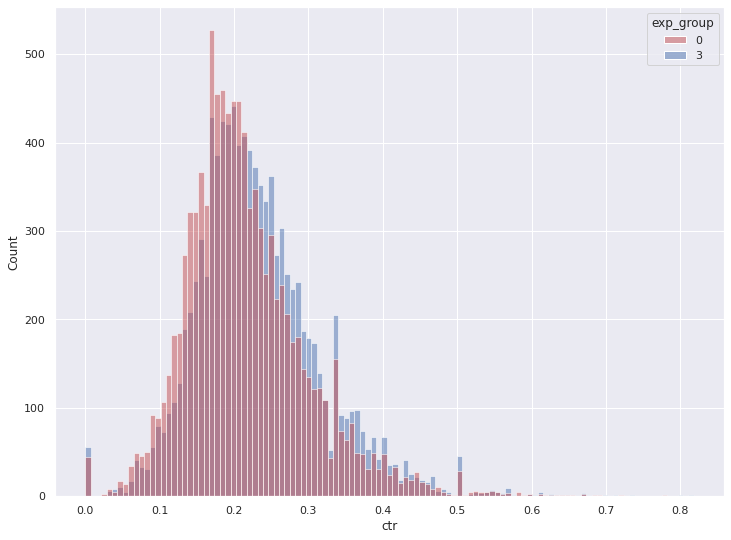

In [10]:
sns.set(rc={'figure.figsize':(12, 9)})

sns.histplot(data=df, 
              x='ctr', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

6. Применим t-тест к метрике линеаризованных лайков обеих групп

In [11]:
stats.ttest_ind(df[df.exp_group == 0].linearized_likes,
                df[df.exp_group == 3].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=-15.21499546090383, pvalue=5.4914249479687664e-52)

Тест показал, что различия есть (p-value < 0.05)

6.1. Построим гистограмму распределения линеаризованных лайков

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

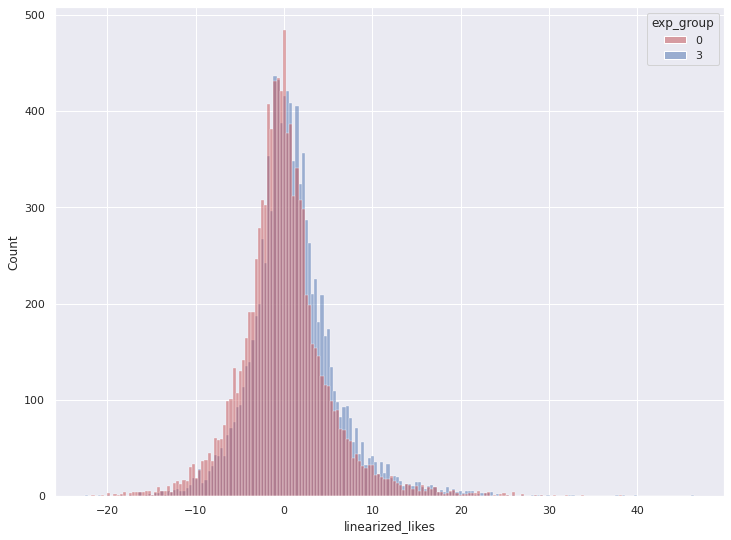

In [12]:
sns.histplot(data=df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

### Вывод

Оба t-теста в группах 0 и 3 показали статистически значимое различие между ними (p-value < 0.05).

p-value в t-тесте по метрике линеаризованных лайков меньше, чем в t-тесте по CTR, следовательно, тест чувствительнее.

### Проанализируем тест между группами 1 и 2 по метрике линеаризованных лайков

7. Формируем общий dataframe для пользователей групп 1 и 2

In [13]:
q = """
SELECT exp_group, 
       user_id,
       sum(action = 'like') AS likes,
       sum(action = 'view') AS views,
       likes / views AS ctr
  FROM {db}.feed_actions 
 WHERE toDate(time) BETWEEN '2023-01-01' AND '2023-01-07'
   AND exp_group IN (1, 2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

In [14]:
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


8. Для каждого пользователя обеих групп рассчитаем метрику линеаризованных лайков

8.1. Считаем общий CTR в контрольной группе

In [15]:
ctr_control = df[df.exp_group == 1].likes.sum() / df[df.exp_group == 1].views.sum()

8.2. Рассчитаем метрику линеаризованных лайков

In [16]:
df['linearized_likes'] = df['likes'] - ctr_control * df['views']

9. Применим t-тест к CTR обеих групп

In [17]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

Тест показал, что различий нет (p-value > 0.05)

9.1. Построим гистограмму распределения CTR

<AxesSubplot:xlabel='ctr', ylabel='Count'>

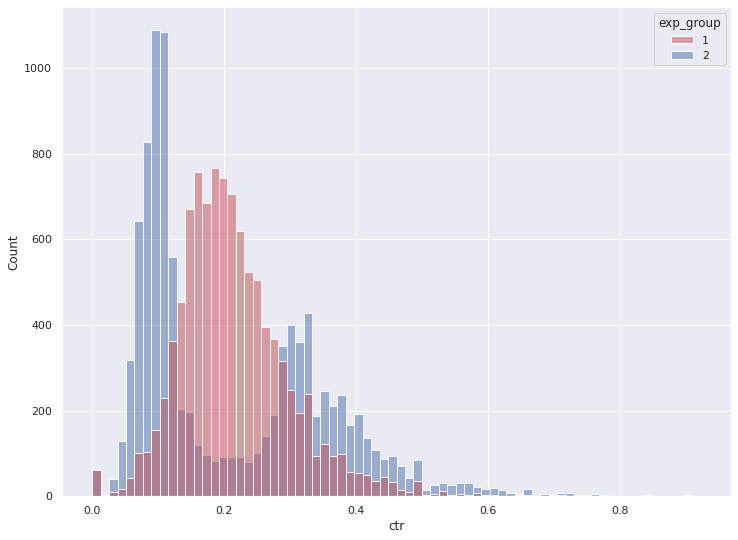

In [18]:
sns.histplot(data=df, 
              x='ctr', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

10. Применим t-тест к метрике линеаризованных лайков обеих групп

In [19]:
stats.ttest_ind(df[df.exp_group == 1].linearized_likes,
                df[df.exp_group == 2].linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=6.122579994775973, pvalue=9.439432187037712e-10)

Тест показал, что различия есть (p-value < 0.05)

10.1. Построим гистограмму распределения линеаризованных лайков

<AxesSubplot:xlabel='linearized_likes', ylabel='Count'>

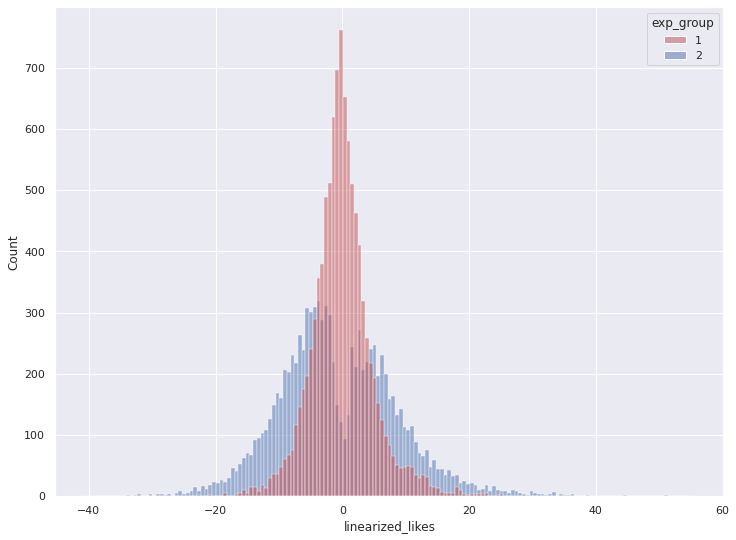

In [20]:
sns.histplot(data=df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette=['r', 'b'],
              alpha=0.5,
              kde=False)

### Вывод

t-тест по CTR в группах 1 и 2 не показал различия между ними (p-value > 0.05).

p-value в t-тесте по метрике линеаризованных лайков намного меньше, чем в t-тесте по CTR (p-value < 0.05), 
этот тест показал различия между группами, следовательно, он чувствительнее.